In [1]:
# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import os
import subprocess

import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn.functional as F
import time

In [3]:
def load_example(df_row):
    image = torchvision.io.read_image(df_row['image_path'])
    
    result = {
        'image': image,
        'class': df_row['Class']
    }
    return result

In [4]:
class HiddenDataset(Dataset):
    def __init__(self, split='train'):
        super().__init__()
        self.examples = []
        if split == 'val':
            df = pd.read_csv(f'FashionMNIST/{split}_mini.csv')
        else:
            df = pd.read_csv(f'FashionMNIST/{split}_mini.csv')
        df['image_path'] = df['Image_File'].apply(
            lambda x: os.path.join('FashionMNIST/train/', x))
        df = df.sort_values(by='image_path')
        df.apply(lambda row: self.examples.append(load_example(row)), axis=1)
        if len(self.examples) == 0:
            raise ValueError('No examples.')

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        image = example['image']
        image = image.to(torch.float32)
        example['image'] = image
        return example

In [5]:
def get_dataset(batch_size):
    train_ds = HiddenDataset(split='train')
    retain_ds = HiddenDataset(split='retain')
    forget_ds = HiddenDataset(split='forget')
    val_ds = HiddenDataset(split='val')

    retain_loader = DataLoader(retain_ds, batch_size=batch_size, shuffle=True)
    forget_loader = DataLoader(forget_ds, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

    return retain_loader, forget_loader, train_loader, val_loader

In [6]:
retain_loader, forget_loader, train_loader, val_loader = get_dataset(64)

In [7]:
# model = resnet18(pretrained=False, num_classes=10) 

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# num_epochs = 10

# for epoch in range(num_epochs):
#     model.train()
#     for i , sample in enumerate(train_loader):

#         inputs = sample["image"]
#         labels = sample["class"]
#         optimizer.zero_grad()

#         # Make 3 channels for RGB
#         inputs = torch.cat((inputs, inputs, inputs), 1)

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# checkpoint_path = 'learned_resnet.pth'
# torch.save(model.state_dict(), checkpoint_path)

In [8]:
def accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images = data['image']
            images = torch.cat((images, images, images), dim=1)
            labels = data['class']
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

In [9]:
# accuracy(model, train_loader)

In [10]:
def kl_loss(model_logits, teacher_logits, temperature=1.):
    teacher_output_softmax = F.softmax(teacher_logits / temperature, dim=1) 
    output_log_softmax = F.log_softmax(model_logits / temperature, dim=1)
    
    kl_div = F.kl_div(output_log_softmax, teacher_output_softmax, reduction='batchmean')
    return kl_div

In [11]:
def soft_cross_entropy(preds, soft_targets):
    loss = torch.sum(-soft_targets * torch.log_softmax(preds, dim=1), dim=1)
    return torch.mean(loss)

In [12]:
acc_retain_unlearned = []
acc_forget_unlearned = []

In [13]:
def unlearning(model, teacher_model, retain_loader, forget_loader, val_loader, temperature=1.,
               weight=None):

    model.conv1.reset_parameters()
    model.fc.reset_parameters()
    
    teacher_model.eval()
    
    retain_epochs = 6
    warmup_epochs = 2
    
    acc_retain_unlearned.append(accuracy(model, retain_loader))
    acc_forget_unlearned.append(accuracy(model, forget_loader))

    criterion = nn.CrossEntropyLoss(weight=weight)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=9e-4, weight_decay=5e-4, momentum=0.9)
    for epoch in range(warmup_epochs):
        print(f'Warmup epoch {epoch+1}/{warmup_epochs}')
        model.train()
        for sample in val_loader:
            x = sample["image"]
            x = torch.cat((x, x, x), dim=1)
            y = sample["class"]
            optimizer.zero_grad()
            student_out = model(x)
            
            with torch.no_grad():
                teacher_out = teacher_model(x)
                
            loss = kl_loss(model_logits=student_out, 
                           teacher_logits=teacher_out, 
                           temperature=temperature)
            loss.backward()
            optimizer.step()
        
        acc_retain_unlearned.append(accuracy(model, retain_loader))
        acc_forget_unlearned.append(accuracy(model, forget_loader))

    optimizer = torch.optim.SGD(model.parameters(),
                                lr=1e-3, weight_decay=5e-4, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=retain_epochs
    )
    for epoch in range(retain_epochs):
        print(f'Retain epoch {epoch+1}/{retain_epochs}')
        model.train()
        for sample in retain_loader:
            x = sample["image"]
            x = torch.cat((x, x, x), dim=1)
            y = sample["class"]
            optimizer.zero_grad()
            out = model(x)
            with torch.no_grad():
                teacher_out = teacher_model(x)
            soft_labels = torch.softmax(teacher_out / temperature, dim=1)
            soft_predictions = torch.log_softmax(out / temperature, dim=1)
            loss = soft_cross_entropy(soft_predictions, soft_labels)
            loss += criterion(out, y)
            loss += kl_loss(model_logits=out, 
                           teacher_logits=teacher_out, 
                           temperature=temperature)
            loss.backward()
            optimizer.step()
        scheduler.step()

        acc_retain_unlearned.append(accuracy(model, retain_loader))
        acc_forget_unlearned.append(accuracy(model, forget_loader))

    model.eval()

In [14]:
original_net = resnet18(weights=None, num_classes=10)
original_net.load_state_dict(torch.load('learned_resnet.pth'))

unleaned_net = resnet18(weights=None, num_classes=10)
unleaned_net.load_state_dict(torch.load('learned_resnet.pth'))

start = time.process_time()
unlearning(unleaned_net , original_net , retain_loader , forget_loader , val_loader , 5 , None)
time_unlearned = time.process_time() - start

state = unleaned_net.state_dict()
torch.save(state, 'unlearned_resnet_resetting_layer.pth')

Warmup epoch 1/2
Warmup epoch 2/2
Retain epoch 1/6
Retain epoch 2/6
Retain epoch 3/6
Retain epoch 4/6
Retain epoch 5/6
Retain epoch 6/6


In [15]:
acc_forget_retain = []
acc_retain_retain = []

In [16]:
retain_loader, forget_loader, train_loader , val_loader= get_dataset(64)

retained_net = resnet18(pretrained=False, num_classes=10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(retained_net.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10

acc_forget_retain.append(accuracy(retained_net, forget_loader))
acc_retain_retain.append(accuracy(retained_net, retain_loader))

start = time.process_time()
for epoch in range(num_epochs):
    retained_net.train()
    for i, sample in enumerate(retain_loader):

        inputs = sample["image"]
        labels = sample["class"]
        optimizer.zero_grad()

        # Make 3 channels for RGB
        inputs = torch.cat((inputs, inputs, inputs), 1)

        outputs = retained_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    acc_forget_retain.append(accuracy(retained_net, forget_loader))
    acc_retain_retain.append(accuracy(retained_net, retain_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

time_retained = (time.process_time() - start)

checkpoint_path = "retained_resnet.pth"
torch.save(retained_net.state_dict(), checkpoint_path)

c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Inder\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.5319032669067383
Epoch 2/10, Loss: 2.425076484680176
Epoch 3/10, Loss: 2.304307460784912
Epoch 4/10, Loss: 2.03122615814209
Epoch 5/10, Loss: 1.7531808614730835
Epoch 6/10, Loss: 1.5702983140945435
Epoch 7/10, Loss: 1.242610216140747
Epoch 8/10, Loss: 1.4090992212295532
Epoch 9/10, Loss: 0.8168389797210693
Epoch 10/10, Loss: 0.49973469972610474


In [17]:
print("Original Model Accuracy on Retained Set:" , accuracy(original_net, retain_loader))
print("Original Model Accuracy on Forget Set:" , accuracy(original_net, forget_loader))

print("Unlearned Model Accuracy on Retained Set:" , accuracy(unleaned_net, retain_loader))
print("Unlearned Model Accuracy on Forget Set:" , accuracy(unleaned_net, forget_loader))

print("Retained Model Accuracy on Retained Set:" , accuracy(retained_net, retain_loader))
print("Retained Model Accuracy on Forget Set:" , accuracy(retained_net, forget_loader))

Original Model Accuracy on Retained Set: 98.375
Original Model Accuracy on Forget Set: 98.5
Unlearned Model Accuracy on Retained Set: 95.25
Unlearned Model Accuracy on Forget Set: 8.5
Retained Model Accuracy on Retained Set: 98.75
Retained Model Accuracy on Forget Set: 9.5


In [18]:
# Print the time taken for unlearning and retaining
print(f"Time taken for unlearning: {time_unlearned}")
print(f"Time taken for retaining: {time_retained}")

Time taken for unlearning: 171.953125
Time taken for retaining: 210.890625


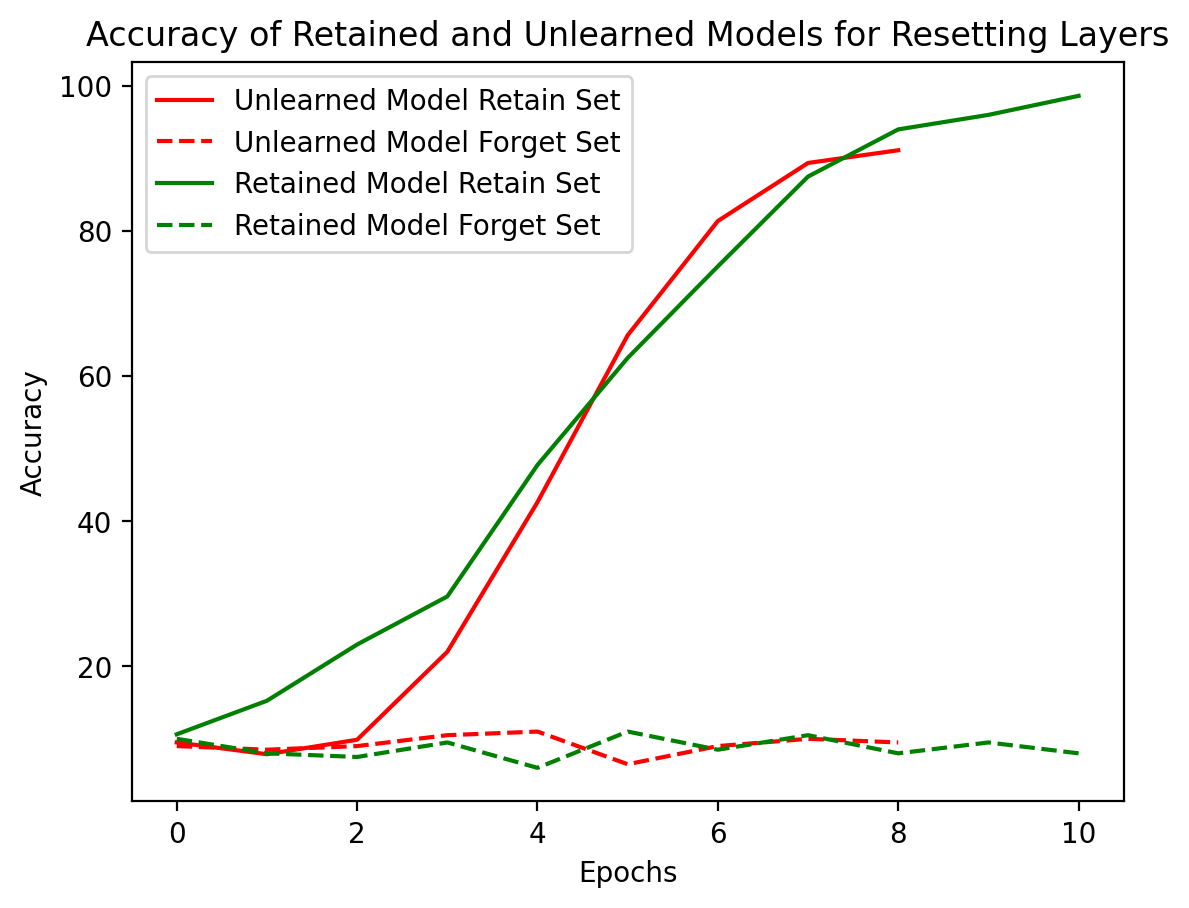

In [19]:
# Plot the accuracy of the models
import matplotlib.pyplot as plt

plt.plot(acc_retain_unlearned, label="Unlearned Model Retain Set" , color = 'red')
plt.plot(acc_forget_unlearned, label="Unlearned Model Forget Set" , color = 'red' , linestyle = 'dashed')
plt.plot(acc_retain_retain, label="Retained Model Retain Set" , color = 'green')
plt.plot(acc_forget_retain, label="Retained Model Forget Set" , color = 'green' , linestyle = 'dashed')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy of Retained and Unlearned Models for Resetting Layers")
plt.savefig("posterimgs/acc_rl.png")
plt.show()

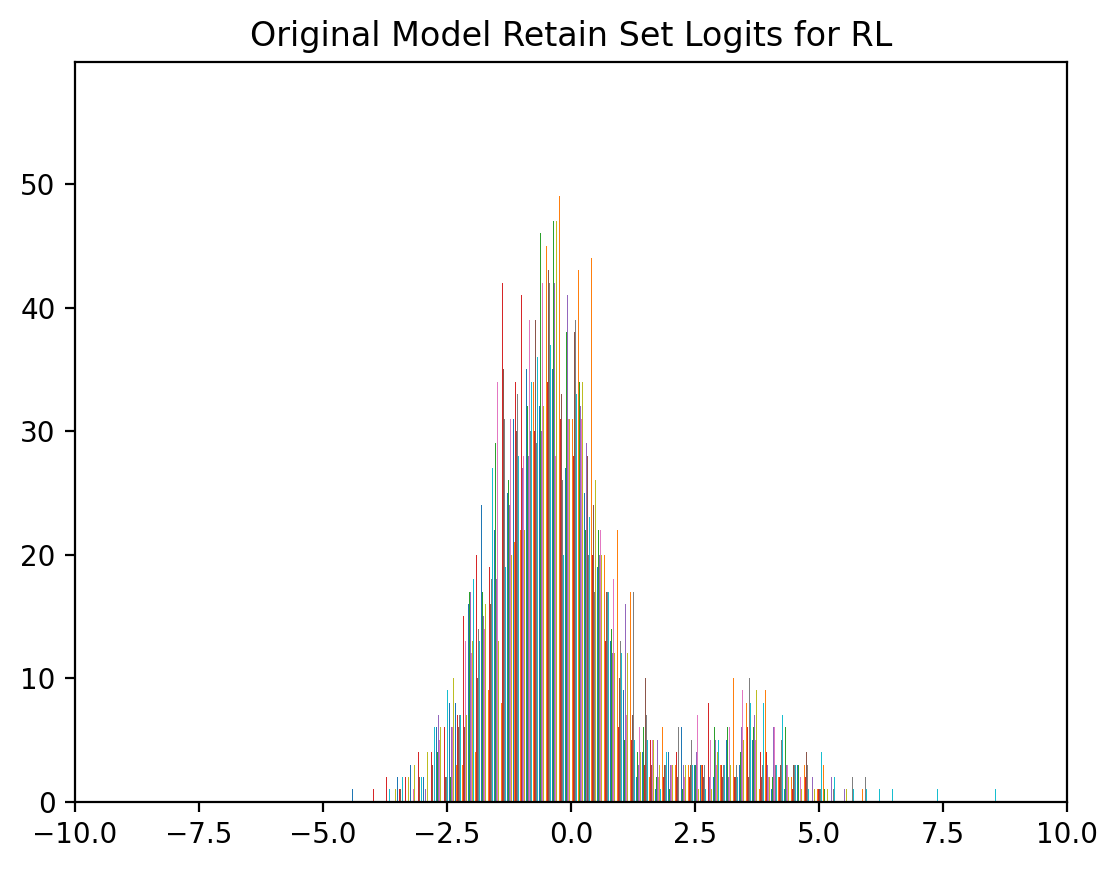

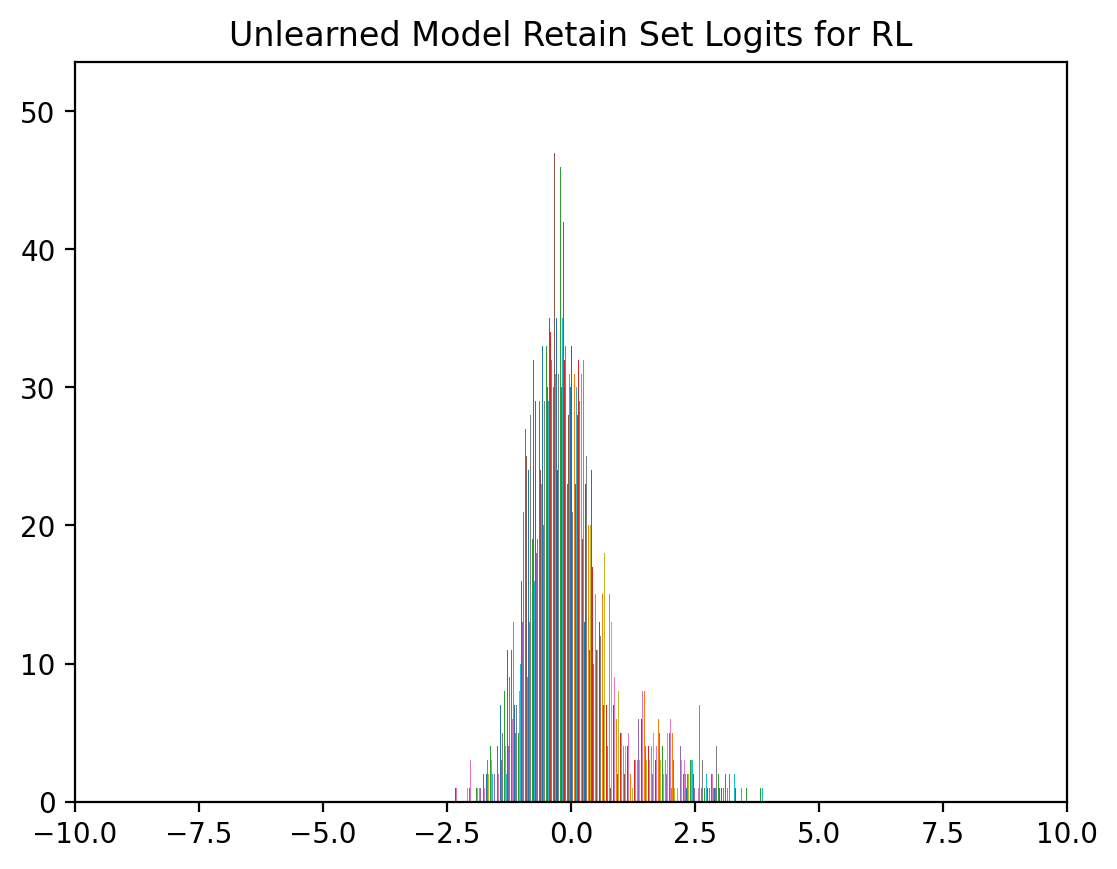

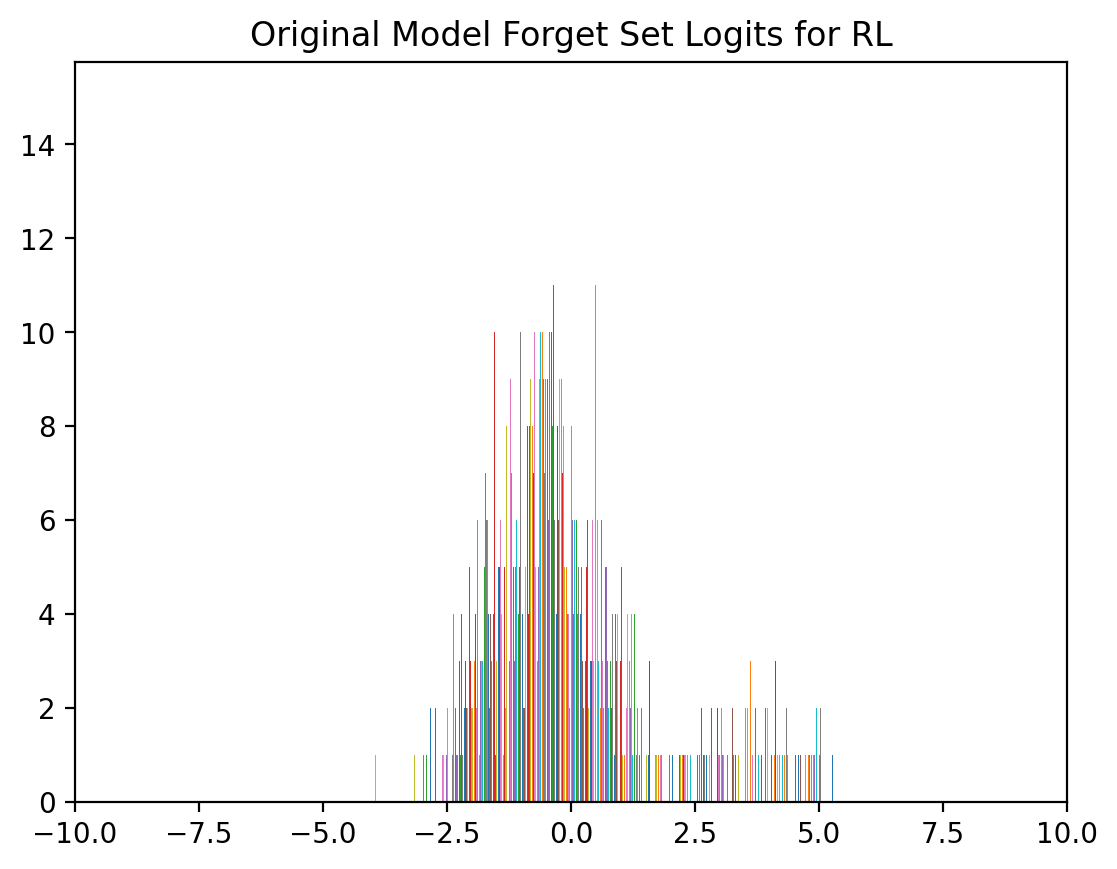

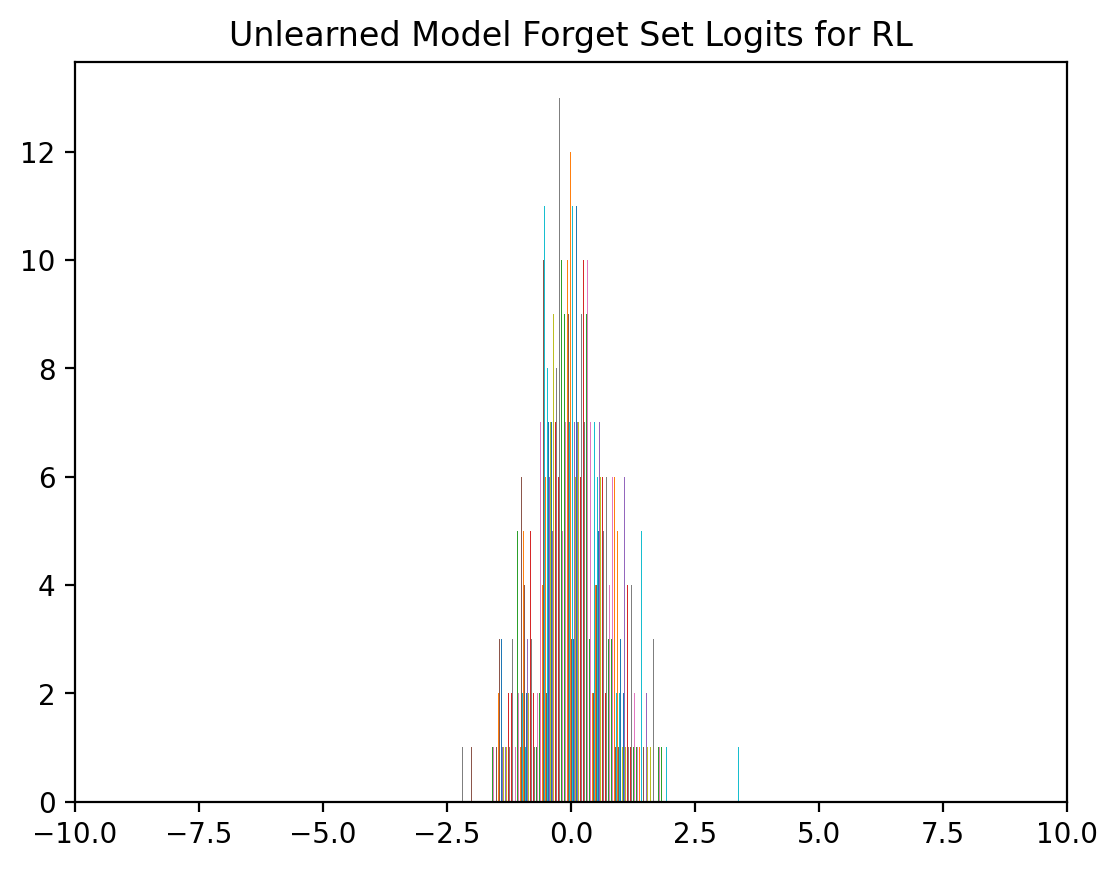

In [20]:
# Plot a histogram of logits for the retained set of the original model and the unlearned model
import matplotlib.pyplot as plt
import numpy as np

def plot_logits(net, dataloader , title , name):
    logits = []
    with torch.no_grad():
        for data in dataloader:
            images = data['image']
            images = torch.cat((images, images, images), dim=1)
            labels = data['class']
            outputs = net(images)
            logits.extend(outputs.numpy())
    logits = np.array(logits)
    plt.hist(logits, bins=100)
    plt.xlim(-10, 10)
    plt.title(title)
    path = f"posterimgs/{name}.png"
    plt.savefig(path)
    plt.show()

plot_logits(original_net, retain_loader , "Original Model Retain Set Logits for RL" , "original_retain_logits_rl")
plot_logits(unleaned_net, retain_loader , "Unlearned Model Retain Set Logits for RL" , "unlearned_retain_logits_rl")

# Plot a histogram of logits for the forget set of the original model and the unlearned model
plot_logits(original_net, forget_loader , "Original Model Forget Set Logits for RL" , "original_forget_logits_rl")
plot_logits(unleaned_net, forget_loader , "Unlearned Model Forget Set Logits for RL" , "unlearned_forget_logits_rl")